In [ ]:
%env DSP_CACHEBOOL=False

## We're going to use DSPy to build a simple SMS classifier using open-source models

### Prerequisites
### Software
* Python >=3.12
* [Poetry](https://python-poetry.org/docs/) - for keeping Python deps clean
* [Docker](https://docs.docker.com/get-docker/) - for running containers
* [Docker Compose](httpshttps://docs.docker.com/compose/install/) - for multi-container apps
* [Ollama](https://ollama.com/) - for running LLMs locally with ease
* [Langfuse](https://github.com/langfuse/langfuse) - for LLM-apps observability and LLM evalutation

### Hardware

*  GPU >= 16GB VRAM with CUDA or MPS (Metal Performance Shaders - Apple Silicon chips M1/M2/M3) support
or
*  access to LLMs hosted on-premise or in the cloud, e.g. Azure AI Studio

## Let's first define connection to the local LLMs served with Ollama

In [ ]:
import dspy

# llama3.1:8b
lm_llama3 = dspy.OllamaLocal(
    model="llama3.1:8b",
)
dspy.configure(lm=lm_llama3)

# qwen2.5:3b
lm_qwen25 = dspy.OllamaLocal(
    model="qwen2.5:3b",
)

## Then define the simple class-based prompt signature for the SMS classifier

* extend `Signature` class
* specify input and output without enforcing any schema checks

In [ ]:
class SMSClassifierNaiveSignature(dspy.Signature):
    """
    Given an SMS text, predict whether it is ham, spam, or smishing.
    Output only the predicted label.
    """

    text = dspy.InputField(desc="The SMS text to classify")
    label = dspy.OutputField(desc="The predicted label")

## Next define a module(program) by combining the signature and the prompting technique

In [ ]:
classifier = dspy.Predict(SMSClassifierNaiveSignature)

you can run the same program with different models by changing the configuration!

## Finally, let's test the classifier with a sample SMS text

In [ ]:
dspy.configure(lm=lm_qwen25)
classifier(
    text="""Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question"""
)

schema almost ok but should be `spam` not `Spam`

In [ ]:
dspy.configure(lm=lm_llama3)
classifier(
    text="""Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question"""
)

here output is totally wrong prediction with both mixed up input and output even though the model supposed to be more powerful (3B vs 8B)

## Typed prediction
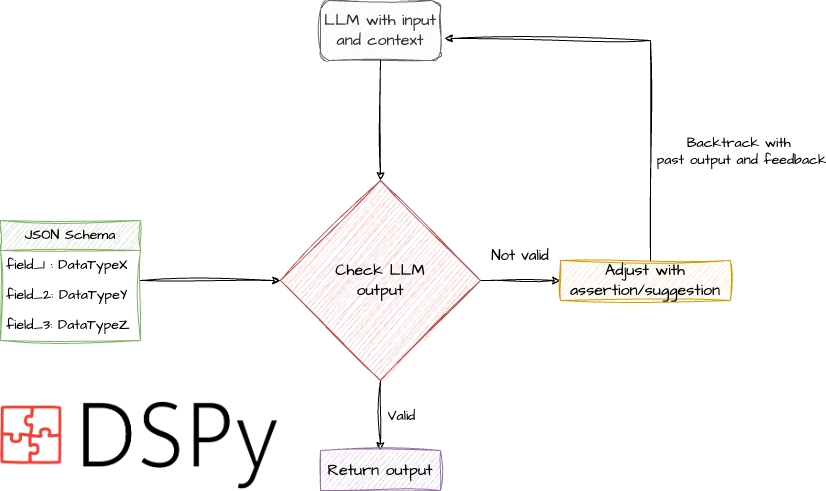




In [ ]:
from enum import Enum

from pydantic import BaseModel, Field


class Label(str, Enum):
    HAM = "ham"
    SPAM = "spam"
    SMISHING = "smishing"


class Input(BaseModel):
    text: str = Field(description="SMS text to be classified")


class Output(BaseModel):
    label: Label = Field(description="The predicted label for the SMS text")


class SMSClassifierSignature(dspy.Signature):
    """
    Given an SMS text, predict whether it is ham, spam, or smishing.
    Output only the predicted label.
    """

    input: Input = dspy.InputField()
    output: Output = dspy.OutputField()

## Different prompting technique with enforcing the schema

Here we use `TypedPredictor` not `Predict` module.

In [ ]:
classifier_struct = dspy.TypedPredictor(SMSClassifierSignature, max_retries=2)

In [ ]:
dspy.configure(lm=lm_qwen25)
classifier_struct(
    input=Input(
        text="""Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question"""
    )
)

In [ ]:
dspy.configure(lm=lm_llama3)
classifier_struct(
    input=Input(
        text="""Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question"""
    )
)

...and you see what may happen ;-)

if you're surprised by what you've just seen  you should read [Let Me Speak Freely? A Study on the Impact of Format Restrictions on Performance of Large Language Models](https://arxiv.org/abs/2408.02442v1)